# 6.1.3 Reissner-Mindlin plate

To avoid shear locking when the thickness $t$ becomes small several methods and elements have been proposed. We discuss two approaches:

1: Mixed Interpolation of Tensorial Components (MITC)

2: Rotations in Nèdèlec space using the Tangential-Displacement Normal-Normal-Stress method (TDNNS)

## Mixed Interpolation of Tensorial Components (MITC)

In [1]:
from ngsolve import *
from netgen.geom2d import SplineGeometry
from ngsolve.webgui import Draw

Set up benchmark example with exact solution. Young modulus $E$, Poisson ratio $\nu$, shear correction factor $\kappa$ and corresponding Lamè parameters $\mu$ and $\lambda$. Geometry parameters are given by thickness $t$ and radius $R$.

In [2]:
E, nu, k = 10.92, 0.3, 5/6
mu  = E/(2*(1+nu))
lam = E*nu/(1-nu**2)
#shearing modulus
G = E/(2*(1+nu))
#thickness, shear locking with t=0.1
t = 0.1
R = 5
#force
fz = 1

order = 1

Due to symmetry we only need to mesh one quarter of the circle.

In [3]:
sg = SplineGeometry()
pnts = [ (0,0), (R,0), (R,R), (0,R) ]
pind = [ sg.AppendPoint(*pnt) for pnt in pnts ]
sg.Append(['line',pind[0],pind[1]], leftdomain=1, rightdomain=0, bc="bottom")
sg.Append(['spline3',pind[1],pind[2],pind[3]], leftdomain=1, rightdomain=0, bc="circ")
sg.Append(['line',pind[3],pind[0]], leftdomain=1, rightdomain=0, bc="left")
mesh = Mesh(sg.GenerateMesh(maxh=R/3))
mesh.Curve(order)
Draw(mesh)

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2006-15-g219a31ff', 'mesh_dim': 2, 'order2d': 1, 'order3d': 1, …

Depending on the boundary conditions (simply supported or clamped) we have different exact solutions for the vertical displacement. 

In [4]:
r = sqrt(x**2+y**2)
xi = r/R
Db = E*t**3/(12*(1-nu**2))

clamped = True

#exact solution for simply supported bc
w_s_ex = -fz*R**4/(64*Db)*(1-xi**2)*( (6+2*nu)/(1+nu) - (1+xi**2) + 8*(t/R)**2/(3*k*(1-nu)))
#Draw(w_s_ex, mesh, "w_s_ex")
#exact solution for clamped bc
w_c_ex = -fz*R**4/(64*Db)*(1-xi**2)*( (1-xi**2) + 8*(t/R)**2/(3*k*(1-nu)))
Draw(w_c_ex, mesh, "w_c_ex")

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2006-15-g219a31ff', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, …

Use (lowest order) Lagrangian finite elements for rotations and the vertical deflection together with additional internal bubbles for order >1.

In [5]:
if clamped:
    fesB = VectorH1(mesh, order=order, orderinner=order+1, dirichletx="circ|left", dirichlety="circ|bottom", autoupdate=True)
else:
    fesB = VectorH1(mesh, order=order, orderinner=order+1, dirichletx="left", dirichlety="bottom", autoupdate=True)
fesW = H1(mesh, order=order, orderinner=order+1, dirichlet="circ", autoupdate=True)
fes = FESpace( [fesB, fesW], autoupdate=True ) 
(beta,u), (dbeta,du) = fes.TnT()

Direct approach where shear locking may occur
$$\frac{t^3}{12}\int_{\Omega} 2\mu\, \varepsilon(\beta):\varepsilon(\delta\beta) + \lambda\, \text{div}(\beta)\text{div}(\delta\beta)\,dx + t\kappa\,G\int_{\Omega}(\nabla u-\beta)\cdot(\nabla\delta u-\delta\beta)\,dx = \int_{\Omega} f\,\delta u\,dx,\qquad \forall (\delta u,\delta\beta). $$

Adding interpolation (reduction) operator $\boldsymbol{R}:[H^1_0(\Omega)]^2\to H(\text{curl})$. Spaces are chosen according to [<a href="http://math.aalto.fi/~rstenber/Publications/M3AS91.pdf">Brezzi, Fortin and Stenberg. Error analysis of mixed-interpolated elements for Reissner-Mindlin plates. <i>Mathematical Models and Methods in Applied Sciences 1</i>, 2
  (1991), 125-151.</a>]
$$\frac{t^3}{12}\int_{\Omega} 2\mu\, \varepsilon(\beta):\varepsilon(\delta\beta) + \lambda\, \text{div}(\beta)\text{div}(\delta\beta)\,dx + t\kappa\,G\int_{\Omega}\boldsymbol{R}(\nabla u-\beta)\cdot\boldsymbol{R}(\nabla\delta u-\delta\beta)\,dx = \int_{\Omega} f\,\delta u\,dx,\qquad \forall (\delta u,\delta\beta). $$

In [6]:
Gamma = HCurl(mesh,order=order,orderedge=order-1, autoupdate=True)

a = BilinearForm(fes)
a += t**3/12*(2*mu*InnerProduct(Sym(grad(beta)),Sym(grad(dbeta))) + lam*div(beta)*div(dbeta))*dx
#a += t*k*G*InnerProduct( grad(u)-beta, grad(du)-dbeta )*dx
a += t*k*G*InnerProduct(Interpolate(grad(u)-beta,Gamma), Interpolate(grad(du)-dbeta,Gamma))*dx

f = LinearForm(fes)
f += -fz*du*dx

gfsol = GridFunction(fes, autoupdate=True)
gfbeta, gfu = gfsol.components

Define function for solving the problem.

In [7]:
def SolveBVP():
    fes.Update()
    gfsol.Update()
    with TaskManager():
        a.Assemble()
        f.Assemble()
        inv = a.mat.Inverse(fes.FreeDofs(), inverse="sparsecholesky")
        gfsol.vec.data = inv * f.vec

Solve, compute error, refine, ...

In [8]:
l = []
for i in range(5):
    print("i = ", i)
    SolveBVP()
    if clamped:
        norm_w = sqrt(Integrate(w_c_ex*w_c_ex, mesh))
        err = sqrt(Integrate((gfu-w_c_ex)*(gfu-w_c_ex), mesh))/norm_w
    else:
        norm_w = sqrt(Integrate(w_s_ex*w_s_ex, mesh))
        err = sqrt(Integrate((gfu-w_s_ex)*(gfu-w_s_ex), mesh))/norm_w
    print("err = ", err)
    l.append ( (fes.ndof, err ))
    mesh.Refine()

i =  0
err =  0.5595598334580394
i =  1
err =  0.11654484017140619
i =  2
err =  0.02144878939866747
i =  3
err =  0.004856535568098415
i =  4
err =  0.00117481588981459


Convergence plot with matplotlib.

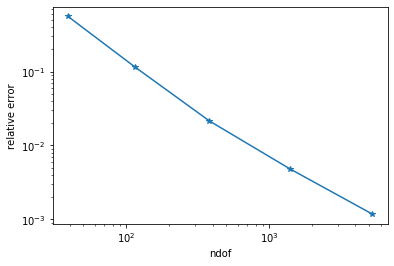

In [10]:
import matplotlib.pyplot as plt

plt.yscale('log')
plt.xscale('log')
plt.xlabel("ndof")
plt.ylabel("relative error")
ndof,err = zip(*l)
plt.plot(ndof,err, "-*")
plt.ion()
plt.show()

## TDNNS method

Invert material law of Hooke and reset mesh.

In [11]:
def CMatInv(mat, E, nu):
    return (1+nu)/E*(mat-nu/(nu+1)*Trace(mat)*Id(2))

mesh = Mesh(sg.GenerateMesh(maxh=R/3))
mesh.Curve(order)
Draw(mesh)

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2006-15-g219a31ff', 'mesh_dim': 2, 'order2d': 1, 'order3d': 1, …

Instead of using Lagrangian elements together with an interpolation operator we can directly use H(curl) for the roation $\beta$.

In [12]:
order=1
if clamped:
    fesB = HCurl(mesh, order=order-1, dirichlet="circ", autoupdate=True)
    fesS = HDivDiv(mesh, order=order-1, dirichlet="", autoupdate=True)  
else:
    fesB = HCurl(mesh, order=order-1)
    fesS = HDivDiv(mesh, order=order-1, dirichlet="circ", autoupdate=True)
fesW = H1(mesh, order=order, dirichlet="circ", autoupdate=True)

fes = FESpace( [fesW, fesB, fesS], autoupdate=True ) 
(u,beta,sigma), (du,dbeta,dsigma) = fes.TnT()

Use the TDNNS method with the stress (bending) tensor $\boldsymbol{\sigma}$ as proposed in [<a href="https://link.springer.com/article/10.1007/s00211-017-0883-9">Pechstein and Schöberl. The TDNNS method for Reissner-Mindlin plates. <i> Numerische Mathematik 137</i>, 3 (2017), 713-740</a>]
\begin{align*}
&\mathcal{L}(u,\beta,\boldsymbol{\sigma})=-\frac{6}{t^3}\|\boldsymbol{\sigma}\|^2_{\mathcal{C}^{-1}} + \langle \boldsymbol{\sigma}, \nabla \beta\rangle + \frac{tkG}{2}\|\nabla u-\beta\|^2 -\int_{\Omega} f\cdot u\,dx\\
&\langle \boldsymbol{\sigma}, \nabla \beta\rangle:= \sum_{T\in\mathcal{T}}\int_T\boldsymbol{\sigma}:\nabla \beta\,dx -\int_{\partial T}\boldsymbol{\sigma}_{nn}\beta_n\,ds
\end{align*}

In [13]:
n = specialcf.normal(2)
    
a = BilinearForm(fes)
a += (-12/t**3*InnerProduct(CMatInv(sigma, E, nu),dsigma) + InnerProduct(dsigma,grad(beta)) + InnerProduct(sigma,grad(dbeta)))*dx
a += ( -((sigma*n)*n)*(dbeta*n) - ((dsigma*n)*n)*(beta*n) )*dx(element_boundary=True)
a += t*k*G*InnerProduct( grad(u)-beta, grad(du)-dbeta )*dx

f = LinearForm(fes)
f += -fz*du*dx

gfsol = GridFunction(fes, autoupdate=True)
gfu, gfbeta, gfsigma = gfsol.components

In [14]:
def SolveBVP():
    fes.Update()
    gfsol.Update()
    with TaskManager():
        a.Assemble()
        f.Assemble()
        inv = a.mat.Inverse(fes.FreeDofs())
        gfsol.vec.data = inv * f.vec

Solve, compute error, and refine.

In [15]:
l = []
for i in range(5):
    print("i = ", i)
    SolveBVP()
    if clamped:
        norm_w = sqrt(Integrate(w_c_ex*w_c_ex, mesh))
        err = sqrt(Integrate((gfu-w_c_ex)*(gfu-w_c_ex), mesh))/norm_w
    else:
        norm_w = sqrt(Integrate(w_s_ex*w_s_ex, mesh))
        err = sqrt(Integrate((gfu-w_s_ex)*(gfu-w_s_ex), mesh))/norm_w
    print("err = ", err)
    l.append ( (fes.ndof, err ))
    mesh.Refine()

i =  0
err =  0.48069152680520477
i =  1
err =  0.16608403907793953
i =  2
err =  0.04302102327996122
i =  3
err =  0.011002228689891142
i =  4
err =  0.00288793351222872


Convergence plot with matplotlib.

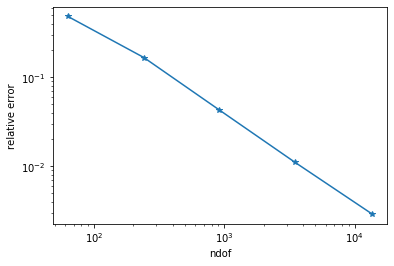

In [17]:
plt.yscale('log')
plt.xscale('log')
plt.xlabel("ndof")
plt.ylabel("relative error")
ndof,err = zip(*l)
plt.plot(ndof,err, "-*")

plt.ion()
plt.show()